<a href="https://colab.research.google.com/github/venuraja79/computer-vision/blob/master/O_Ring_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/venuraja79/computer-vision.git

Cloning into 'computer-vision'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [3]:
!pwd

/content


In [0]:
import os
import zipfile

local_zip = '/content/computer-vision/t_good.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

local_zip = '/content/computer-vision/t_damaged.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

local_zip = '/content/computer-vision/validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
!ls /tmp/validation/good

IMG_20190803_061633.jpg  IMG_20190803_064828.jpg  IMG_20190803_064855.jpg


In [0]:
!mv /tmp/t_damaged /tmp/damaged

In [0]:
!mv /tmp/t_good /tmp/good

In [0]:
!mkdir /tmp/train
!mv /tmp/damaged /tmp/train/damaged
!mv /tmp/good /tmp/train/good

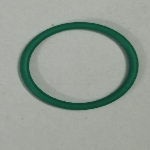

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = '/tmp/train/good/IMG_20190803_061146.jpg'
load_img(img_path, target_size=(150, 150))  # this is a PIL image

In [10]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-10-14 06:45:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   108MB/s    in 0.8s    

2019-10-14 06:45:27 (108 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
last layer output shape:  (None, 7, 7, 768)


In [11]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

# Binary Classifier
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

# Define our example directories and files
base_dir = '/tmp/'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

#train_good_dir = os.path.join(train_dir, 't_good') # Directory with our training good pictures
#train_dam_dir = os.path.join(train_dir, 't_damaged') # Directory with our training damaged pictures
#validation_good_dir = os.path.join(validation_dir, 'good') # Directory with our validation good pictures
#validation_dam_dir = os.path.join(validation_dir, 'damaged')# Directory with our validation damaged pictures

#train_good_fnames = os.listdir(train_good_dir)
#train_dam_fnames = os.listdir(train_dam_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 20 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [18]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 30,
            validation_steps = 5,
            verbose = 2)

Epoch 1/30
Epoch 1/30
10/10 - 67s - loss: 1.8692 - acc: 0.5150 - val_loss: 0.8014 - val_acc: 0.4286
Epoch 2/30
Epoch 1/30
10/10 - 62s - loss: 0.6791 - acc: 0.6250 - val_loss: 0.5792 - val_acc: 0.8571
Epoch 3/30
Epoch 1/30
10/10 - 63s - loss: 0.7101 - acc: 0.6650 - val_loss: 0.6122 - val_acc: 0.7143
Epoch 4/30
Epoch 1/30
10/10 - 63s - loss: 0.5974 - acc: 0.7050 - val_loss: 0.4527 - val_acc: 0.8571
Epoch 5/30
Epoch 1/30
10/10 - 63s - loss: 0.5262 - acc: 0.7300 - val_loss: 0.3801 - val_acc: 0.8571
Epoch 6/30
Epoch 1/30
10/10 - 62s - loss: 0.4718 - acc: 0.7400 - val_loss: 0.3771 - val_acc: 0.8571
Epoch 7/30
Epoch 1/30
10/10 - 63s - loss: 0.5175 - acc: 0.8300 - val_loss: 0.3176 - val_acc: 0.8571
Epoch 8/30
Epoch 1/30
10/10 - 63s - loss: 0.3151 - acc: 0.8400 - val_loss: 0.4597 - val_acc: 0.7143
Epoch 9/30
Epoch 1/30
10/10 - 62s - loss: 0.4387 - acc: 0.8250 - val_loss: 0.2399 - val_acc: 1.0000
Epoch 10/30
Epoch 1/30
10/10 - 62s - loss: 0.1621 - acc: 0.9550 - val_loss: 0.1148 - val_acc: 0.8571

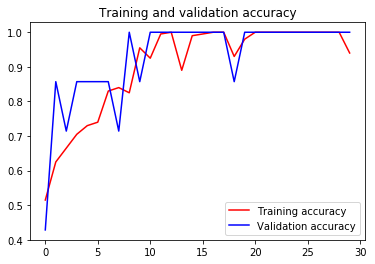

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [36]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a damaged ring!")
    
  else:
    print(fn + " is a good ring!")
 

MessageError: ignored

In [39]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing import image
import numpy as np

folder = '/content/'
filepath = '/tmp/train/good/IMG_20190803_061146.jpg'
#filepath = '/tmp/train/damaged/IMG_20190920_142152.jpg'
#img = image.load_img( folder + , target_size=(150,150,3))
img = image.load_img(filepath, target_size=(150, 150))
  
x= image.img_to_array(img)
x= np.expand_dims(x, axis=0)
pred = model.predict(x, batch_size=1)
print(pred)

if pred[0] > 0:
  print(filepath + " is a good ring!")
else:
  print(filepath + " is a damaged ring!")

[[1.]]
/tmp/train/good/IMG_20190803_061146.jpg is a good ring!
